
# **<center><font style="color:rgb(100,109,254)">Human Action Recognition in Videos </font> </center>**
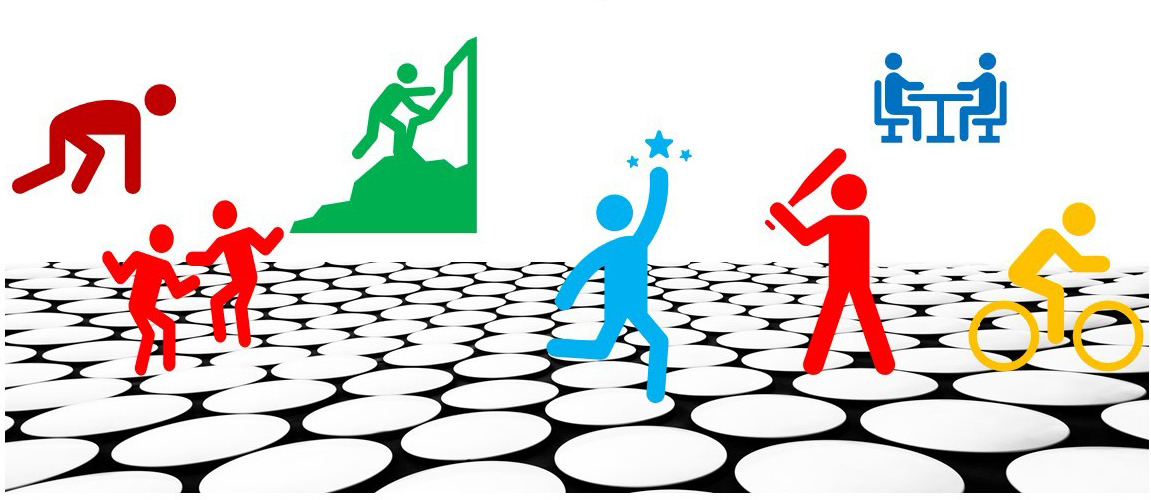

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**



In [66]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [67]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

### **<font style="color:rgb(134,19,348)"> Downloading the dataset</font>**



In [3]:
# # Discard the output of this cell.
# %%capture

# # Downlaod the UCF50 Dataset
# !wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# #Extract the Dataset
# !unrar x UCF50.rar

### **<font style="color:rgb(134,19,348)"> Visualising Labels</font>**



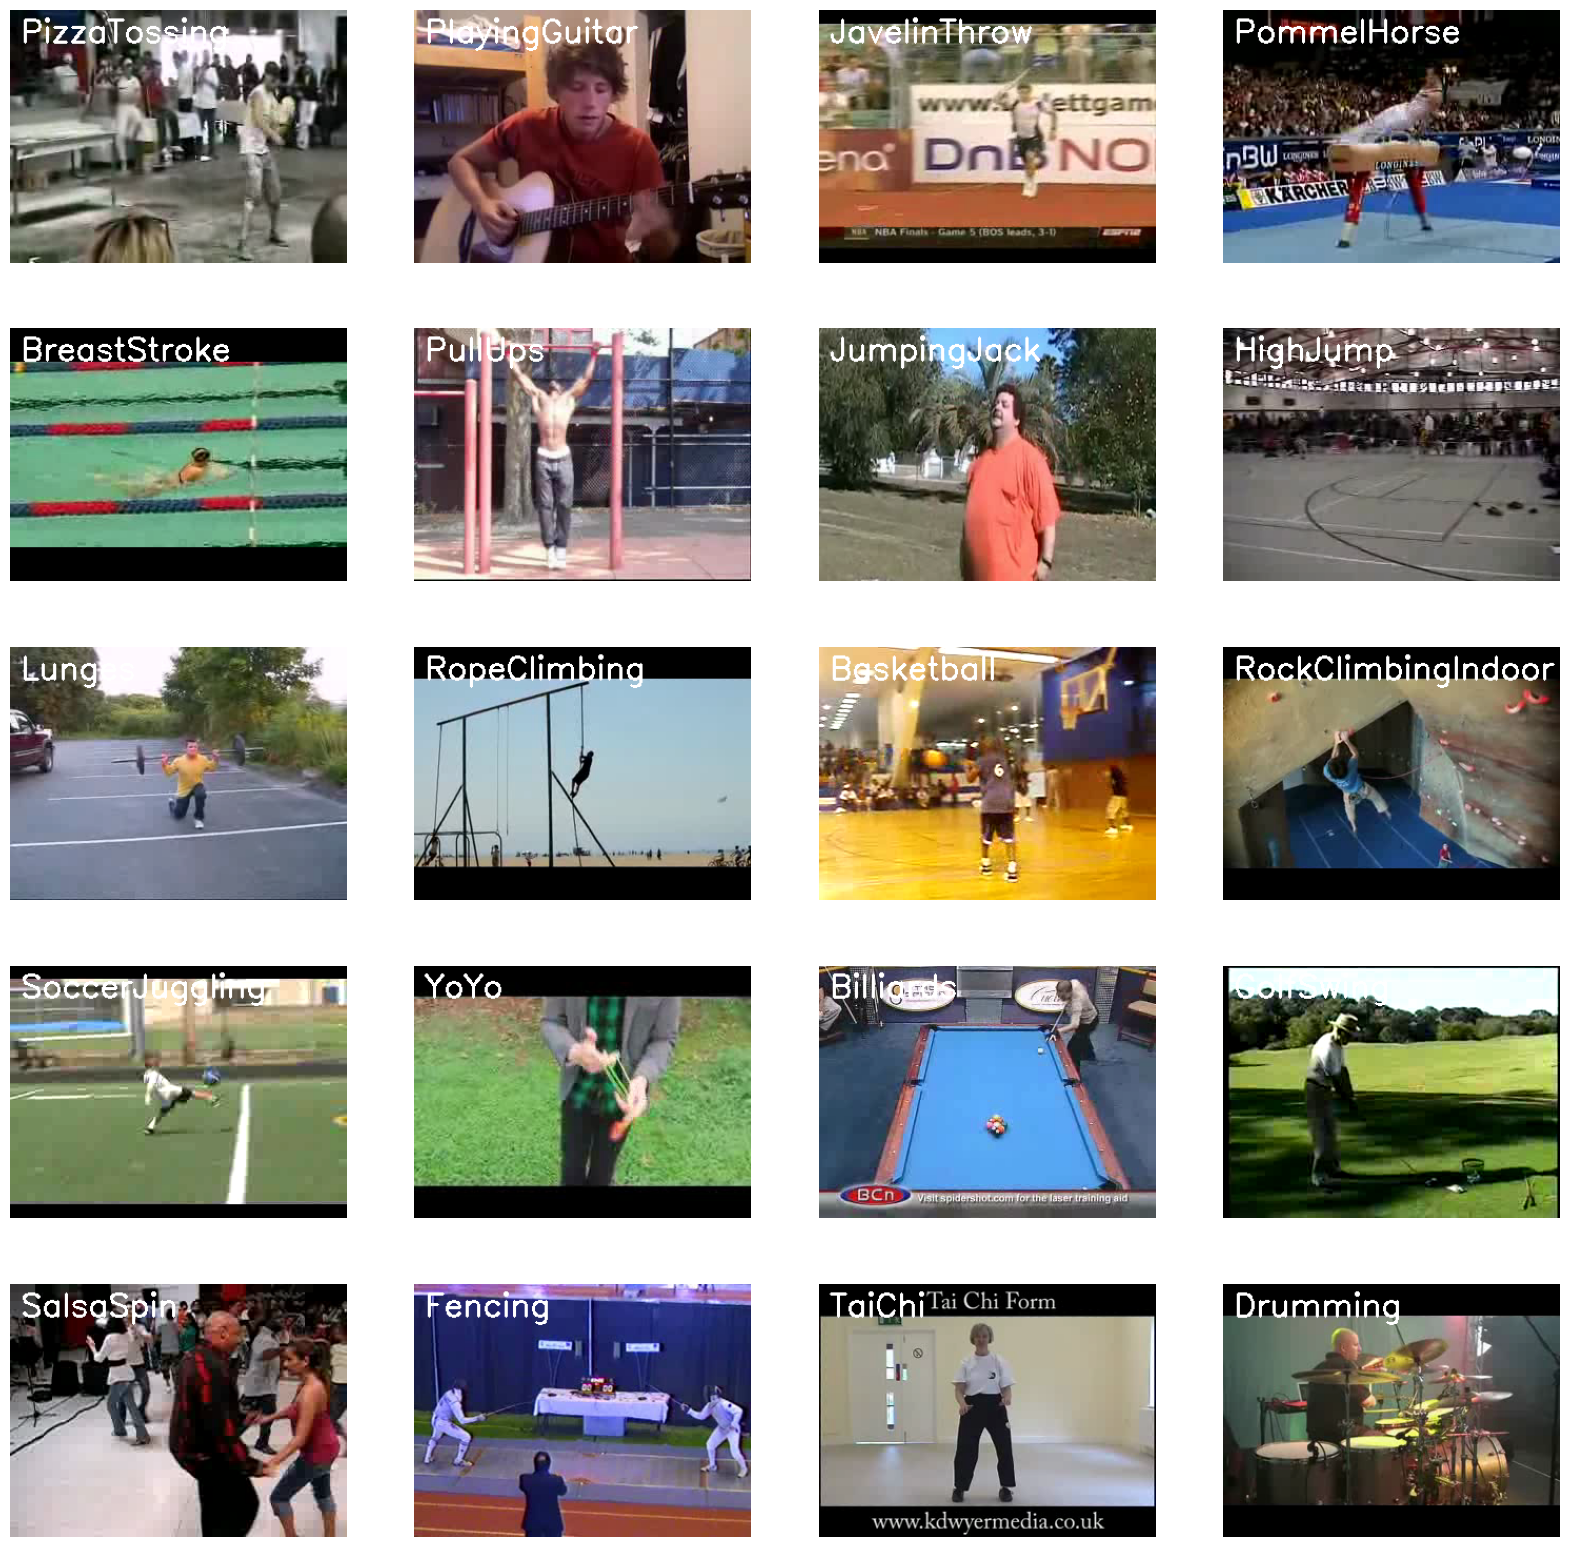

In [68]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in data/UCF50.
all_classes_names = os.listdir('data/UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'data/UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'data/UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## **<font style="color:rgb(134,19,348)">Preprocess the Dataset</font>**


In [73]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
# CLASSES_LIST = ["PlayingGuitar", "TaiChi", "Fencing", "HorseRace","Lunges","RopeClimbing","PullUps"]
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace","Lunges","Punch","PushUps"]

### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**

In [74]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**


In [75]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [76]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
Extracting Data of Class: Lunges
Extracting Data of Class: Punch
Extracting Data of Class: PushUps


In [77]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## **<font style="color:rgb(134,19,348)">Split the Data into Train and Test Set</font>**


In [78]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

## **<font style="color:rgb(134,19,348)">Implement the ConvLSTM Approach</font>**

### **<font style="color:rgb(134,19,348)">Construct the Model</font>**

In [58]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [59]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

/Users/justin/anaconda3/envs/human/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │        20,167 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,167 (207.68 KB)

 Trainable params: 53,167 (207.68 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [60]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### **<font style="color:rgb(134,19,348)">Compile & Train the Model</font>**

In [61]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 56s 391ms/step - accuracy: 0.1733 - loss: 1.9227 - val_accuracy: 0.3284 - val_loss: 1.7742
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 389ms/step - accuracy: 0.3007 - loss: 1.6888 - val_accuracy: 0.4851 - val_loss: 1.4048
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 51s 379ms/step - accuracy: 0.5183 - loss: 1.3693 - val_accuracy: 0.5373 - val_loss: 1.2154
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 363ms/step - accuracy: 0.6144 - loss: 1.0668 - val_accuracy: 0.6493 - val_loss: 1.0226
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 364ms/step - accuracy: 0.6689 - loss: 0.8397 - val_accuracy: 0.6716 - val_loss: 0.8694
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7973 - loss: 0.5776 - val_accuracy: 0.6940 - val_loss: 0.8159
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 371ms/step - accuracy: 0.8695 - loss: 0.4081 - val_accuracy: 0.7090 - val_loss: 0.7543
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 50s 375ms/step - accuracy: 0.8844 - loss: 0

#### **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

In [62]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.7730 - loss: 1.0583


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

In [63]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Plot Model’s Loss & Accuracy Curves</font>**

In [80]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

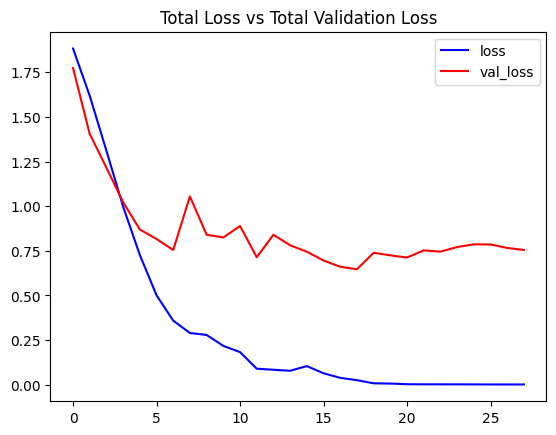

In [65]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

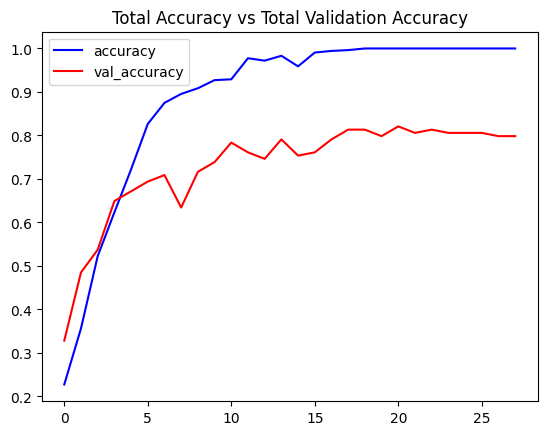

In [66]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### **<font style="color:rgb(134,19,348)">Classification Report and Confusion Matrix</font>**

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [12]:
# convlstm = tf.keras.models.load_model('/content/convlstm_model.h5')


In [69]:
y_pred = convlstm_model.predict(features_test)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(labels_test, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

class_names = CLASSES_LIST

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step


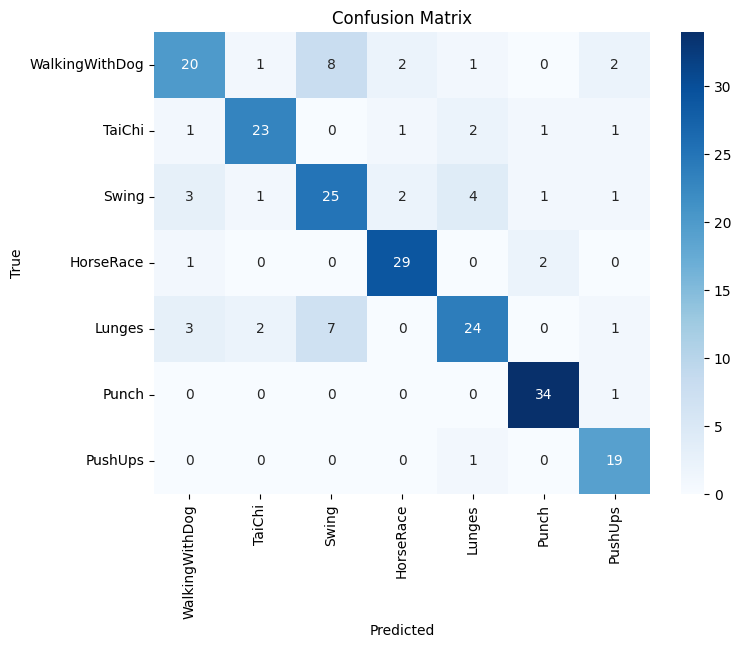

In [70]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [71]:
report = classification_report(y_true, y_pred_classes, target_names=class_names)

# Print the classification report
print(report)

                precision    recall  f1-score   support

WalkingWithDog       0.71      0.59      0.65        34
        TaiChi       0.85      0.79      0.82        29
         Swing       0.62      0.68      0.65        37
     HorseRace       0.85      0.91      0.88        32
        Lunges       0.75      0.65      0.70        37
         Punch       0.89      0.97      0.93        35
       PushUps       0.76      0.95      0.84        20

      accuracy                           0.78       224
     macro avg       0.78      0.79      0.78       224
  weighted avg       0.78      0.78      0.77       224



## **<font style="color:rgb(134,19,348)">Implement the LRCN Approach</font>**


### **<font style="color:rgb(134,19,348)">Construct the Model</font>**

In [81]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    # model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    # model.add(TimeDistributed(MaxPooling2D((2, 2))))
    # model.add(TimeDistributed(Dropout(0.5)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
    model.build(input_shape=(None, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [82]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

/Users/justin/anaconda3/envs/human/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_69             │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_70             │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_71             │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_72             │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_73             │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_74             │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_75             │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_76             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_77             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_78             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,231 (141.53 KB)

 Trainable params: 36,231 (141.53 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [83]:
# Plot the structure of the contructed LRCN model.
# plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)
print(features.shape)

(894, 20, 64, 64, 3)


### **<font style="color:rgb(134,19,348)">Compile & Train the Model</font>**

In [84]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.1647 - loss: 1.9596 - val_accuracy: 0.1716 - val_loss: 1.8910
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.2751 - loss: 1.8073 - val_accuracy: 0.3358 - val_loss: 1.7751
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.3765 - loss: 1.6260 - val_accuracy: 0.4254 - val_loss: 1.5004
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.4501 - loss: 1.4566 - val_accuracy: 0.3657 - val_loss: 1.4968
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.4956 - loss: 1.3668 - val_accuracy: 0.5075 - val_loss: 1.3265
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.5609 - loss: 1.2104 - val_accuracy: 0.5000 - val_loss: 1.2242
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.5683 - loss: 1.1120 - val_accuracy: 0.5597 - val_loss: 1.1081
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.5913 - loss: 1.0116 - 

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

In [85]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8590 - loss: 0.5063


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

In [86]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Plot Model’s Loss & Accuracy Curves</font>**

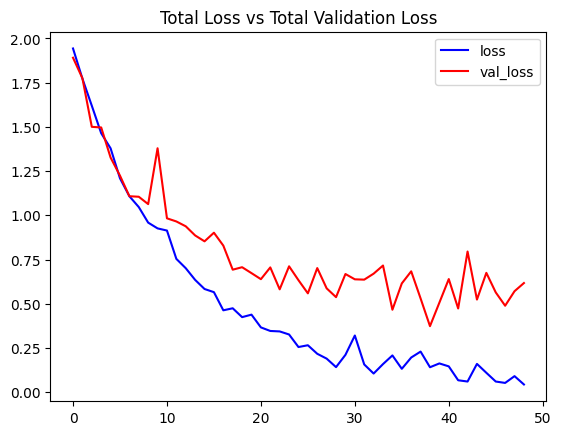

In [87]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

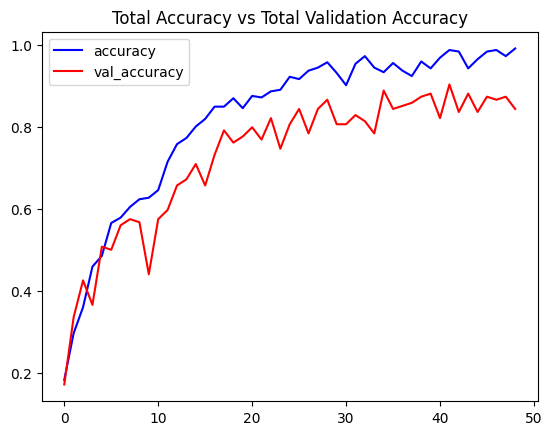

In [88]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### **<font style="color:rgb(134,19,348)">Classification Report and Confusion Matrix</font>**

In [21]:
# lrcn = tf.keras.models.load_model('/content/LRCN_model.h5')


In [89]:
y_pred = LRCN_model.predict(features_test)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(labels_test, axis=1)

class_names = CLASSES_LIST

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


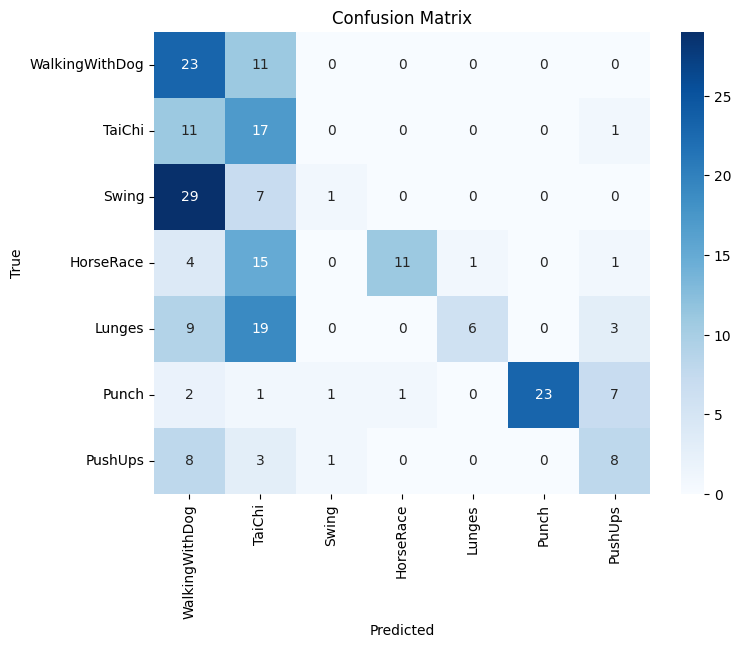

In [90]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [63]:
report = classification_report(y_true, y_pred_classes, target_names=class_names)

# Print the classification report
print(report)

               precision    recall  f1-score   support

PlayingGuitar       0.51      0.50      0.51        44
       TaiChi       0.72      0.41      0.52        32
      Fencing       0.41      0.54      0.46        24
    HorseRace       0.73      0.88      0.80        34
       Lunges       0.67      0.26      0.37        31
 RopeClimbing       0.43      0.36      0.39        36
      PullUps       0.26      0.55      0.35        22

     accuracy                           0.50       223
    macro avg       0.53      0.50      0.49       223
 weighted avg       0.55      0.50      0.50       223

